# IRL

Easy game formalism :

- States = (x, t)
- Action = (&uarr;, &darr;, &rarr;, &larr;)
- Reward = r(x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox

FLOAT_MAX = 1e30

In [2]:
# Gridworld provides a basic environment for RL agents to interact with

class GridWorld:
    """
    Grid world environment
    """
    
    def __init__(self, length_max, height, width, start_pos):
        """
            input: 
            height - idx : height of the spatial grid
            width - idx : width of the spatial grid
            length - idx : temporal length of a trip
            
            start_pos 2-tuple : coordinates within the state_space (height x width)
            
        """
        self.height = height
        self.width = width
        self.length_max = length_max
        
        self.start = (0, start_pos[0], start_pos[1])
        self.end = (length_max-1, start_pos[0], start_pos[1])
        
        self.n_states = self.height*self.width*self.length_max
        
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        self.n_actions = len(self.actions)
        self.neighbors = [(0, 0),(-1, 0),(-1, 1),(0, 1),(1, 1),(1, 0),(1, -1),(0, -1),(-1, -1)]
        self.dirs = {0: 'stay', 1: 'n', 2: 'ne', 3: 'e', 4: 'se', 5: 's', 6: 'sw', 7: 'w', 8: 'nw'}
    
    def get_grid_idx(self):
        return np.array(range(self.n_states)).reshape((self.length_max, self.height, self.width))
    
    def get_list_state(self):
        return [(i,j,k) for i in range(self.length_max) for j in range(self.height) for k in range(self.width)]
    
    def state2idx(self, state):
        """
        input:
          2d state
        returns:
          1d index
        """
        return self.get_grid_idx()[state]

    def idx2state(self, idx):
        """
        input:
          1d idx
        returns:
          2d state
        """
        return self.get_list_state()[idx]
           
    def get_next_state(self, state, action):
        """
        get next state with [action] on [state]
        args
          state     (z, y, x)
          action    int
        returns
          new state
        """
        if state[0] >= self.length_max-1:
            return state
        else :
            inc = self.neighbors[action]
            nei_s = (state[1] + inc[0], state[2] + inc[1])
            if nei_s[0] >= 0 and nei_s[0] < self.height and nei_s[1] >= 0 and nei_s[1] < self.width:
                next_state = (state[0] + 1, nei_s[0], nei_s[1])
            else:
                next_state = (state[0] + 1, state[1], state[2])
            return next_state

    def get_list_previous_state(self, state):
        """
        args
          state     (z, y, x)
        returns
          tuple
              - previous state (z, y, x)
              - associated action int
        """
        previous = []
        for a in self.actions:
            inc = self.neighbors[a]
            nei_s = (state[1] - inc[0], state[2] - inc[1])

            if nei_s[0] >= 0 and nei_s[0] < self.height and nei_s[1] >= 0 and nei_s[1] < self.width:
                previous_state = (state[0] - 1, nei_s[0], nei_s[1])
                previous.append((previous_state,a))
        return previous

    def get_transition_mat(self):
        """
        get transition dynamics of the gridworld
        return:
          P_a         NxNxN_ACTIONS transition probabilities matrix - 
                        P_a[s0, s1, a] is the transition prob of 
                        landing at state s1 when taking action 
                        a at state s0
        """
        P_a = np.zeros((self.n_states, self.n_states, self.n_actions))
        
        for i in range(self.n_states):
            si = self.idx2state(i)
            for a in range(self.n_actions):
                sj = self.get_next_state(si,a)
                j = self.state2idx(sj)
                P_a[i, j, a] = 1                
        return P_a

In [3]:
g = GridWorld(5,3,4,(1,1))

In [4]:
g.get_grid_idx()

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]],

       [[24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35]],

       [[36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]],

       [[48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59]]])

In [5]:
def value_iteration(P_a, rewards, error=0.01, max_iter=100):
    """
    static value iteration function. Perhaps the most useful function in this repo

    inputs:
    P_a         NxNxN_ACTIONS transition probabilities matrix - 
                          P_a[s0, s1, a] is the transition prob of 
                          landing at state s1 when taking action 
                          a at state s0
    rewards     Nx1 matrix - rewards for all the states
    gamma       float - RL discount
    error       float - threshold for a stop

    returns:
    values    Nx1 matrix - estimated values
    policy    Nx1 matrix - policy
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)
    n = 0 
    values = np.ones([N_STATES])* -FLOAT_MAX
    qvalues = np.ones((N_STATES, N_ACTIONS))* -FLOAT_MAX
    policy = np.zeros((N_STATES, N_ACTIONS))
        
    # estimate values
    while True:
        values_tmp = values.copy()
        values[g.state2idx(g.end)] = 0 # goal
        
        for s in range(N_STATES):
            qvalues[s] = [sum([P_a[s, s1, a]*(rewards[s] + values[s1]) for s1 in range(N_STATES)]) for a in range(N_ACTIONS)]
            
            softmax = max(qvalues[s]) + np.log(1.0 + np.exp(min(qvalues[s]) - max(qvalues[s]))) 
            values[s] = rewards[s] + softmax
            
            policy[s,:] = np.exp(qvalues[s]-values[s])/sum(np.exp(qvalues[s]-values[s]))
            
        if max([abs(values[s] - values_tmp[s]) for s in range(N_STATES)]) < error:
            break
        n += 1
        # max iteration
        if n > max_iter:
            print("    WARNING: max number of iterations", max_iter)
            break    
    
    return values, policy

In [6]:
P = g.get_transition_mat()
R = -np.random.random((g.n_states, 1))

values, policy = value_iteration(P, R, 0.01, 100)

values.reshape((g.length_max, g.height, g.width))

array([[[-1.46661996e+00, -1.52591661e-01, -1.58766669e+00,
         -1.91318478e+00],
        [-1.01242706e+00, -4.33060086e-02, -1.35200989e+00,
         -1.05052820e+00],
        [-1.20096265e+00, -1.27595129e-01, -1.89479857e+00,
         -1.76361162e+00]],

       [[-7.24764053e-01, -1.39038292e+00, -1.32574651e+00,
         -2.26107292e+00],
        [-1.22785608e-01, -1.44003294e+00, -1.19979375e+00,
         -1.68175108e+00],
        [-1.11506318e+00, -1.92806850e+00, -1.66445005e+00,
         -2.61931343e+00]],

       [[-6.84147060e-01, -1.84772682e+00, -1.50100507e+00,
         -1.76659398e+00],
        [-2.31850408e-01, -5.86872107e-01, -1.08668789e+00,
         -1.40568990e+00],
        [-1.56537054e+00, -5.49035904e-01, -1.92236743e+00,
         -1.72261046e+00]],

       [[-1.38574013e+00, -6.55353981e-01, -1.30698620e+00,
         -1.00000000e+30],
        [-3.04708461e-01, -1.12242464e+00, -2.59031559e-01,
         -1.00000000e+30],
        [-1.80846441e-02, -1.46464269

In [7]:
policy

array([[0.1132664 , 0.1132664 , 0.1132664 , 0.05821388, 0.05539413,
        0.20679357, 0.1132664 , 0.1132664 , 0.1132664 ],
       [0.07857745, 0.07857745, 0.07857745, 0.08382415, 0.09507575,
        0.07477135, 0.27913125, 0.1528877 , 0.07857745],
       [0.12412236, 0.12412236, 0.12412236, 0.04871278, 0.08694391,
        0.14078312, 0.11071744, 0.11635332, 0.12412236],
       [0.07562616, 0.07562616, 0.07562616, 0.07562616, 0.07562616,
        0.13497965, 0.21856455, 0.19269885, 0.07562616],
       [0.17754846, 0.09724807, 0.04998117, 0.0475602 , 0.02919393,
        0.06582278, 0.17754846, 0.17754846, 0.17754846],
       [0.07681554, 0.0807257 , 0.08611584, 0.09767505, 0.06137422,
        0.04715176, 0.10631185, 0.28676249, 0.15706754],
       [0.17208514, 0.15171998, 0.05954368, 0.10627521, 0.04161537,
        0.10812988, 0.08307257, 0.13533459, 0.14222356],
       [0.11091189, 0.06214151, 0.11091189, 0.11091189, 0.11091189,
        0.04343101, 0.11284748, 0.17959305, 0.15833938],


In [8]:
def compute_state_visition_freq(P_a, start_idx, nb_step, policy):
    """compute the expected states visition frequency p(s| theta, T) 
    using dynamic programming
    inputs:
    P_a     NxNxN_ACTIONS matrix - transition dynamics
    gamma   float - discount factor
    start_idx   idx of start position
    nb_step idx - nb of step to iterate
    policy  Nx1 vector - policy

    returns:
    p       Nx1 vector - state visitation frequencies
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # mu[s, t] is the prob of visiting state s at time t
    mu = np.zeros([N_STATES, nb_step]) 

    mu[start_idx, 0] = 1
    for s in range(N_STATES):
        for t in range(nb_step-1):
            mu[s, t+1] = sum([sum([mu[pre_s, t]*P_a[pre_s, s, a1]*policy[pre_s, a1] for a1 in range(N_ACTIONS)]) for pre_s in range(N_STATES)])

    p = np.sum(mu, 1)
    return p

In [9]:
svf = compute_state_visition_freq(P, g.state2idx((0,1,1)), g.length_max, policy)
svf.reshape((g.length_max, g.height, g.width))

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.15706754, 0.0807257 , 0.08611584, 0.        ],
        [0.28676249, 0.07681554, 0.09767505, 0.        ],
        [0.10631185, 0.04715176, 0.06137422, 0.        ]],

       [[0.15725397, 0.04605123, 0.05174843, 0.01267966],
        [0.27670733, 0.15662656, 0.05336948, 0.02425927],
        [0.06033972, 0.12503319, 0.02478155, 0.01114961]],

       [[0.10097485, 0.11416023, 0.04630851, 0.        ],
        [0.2542643 , 0.07650297, 0.12408051, 0.        ],
        [0.16452846, 0.05645346, 0.06272672, 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]])

In [10]:
g.get_grid_idx()

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]],

       [[24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35]],

       [[36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]],

       [[48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59]]])

In [11]:
## Create expert trajectories

traj_1 = [5, 18, 33, 46, 53]
traj_2 = [5, 22, 30, 45, 53]
traj_3 = [5, 21, 34, 45, 53]
traj_4 = [5, 21, 33, 45, 53]
traj_5 = [5, 22, 34, 42, 53]
traj_6 = [5, 22, 34, 42, 53]

trajs = [traj_1, traj_2, traj_3, traj_4, traj_5, traj_6]


freq = np.zeros((3,4))
for traj in trajs:
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[ 0.,  0.,  0.,  0.],
       [ 0., 12.,  4.,  0.],
       [ 0.,  7.,  7.,  0.]])

In [12]:
## feat_map

map_mask = [[-1, -1, -1, 0],
            [-1, 0, 0, 0],
            [-1, 0, 0, 0]]

map_dist = [[-0.5, -0.5, -0.5, -1],
            [-0.5, 0, -0.5, -1],
            [-0.5, -0.5, -0.5, -1]]

map_gradv = [[0, 0, 0, 0],
            [-0.5, -0.5, -0.5, -0.5],
            [-1, -1, -1, -1]]

map_gradh = [[0, -0.3, -0.6, -0.9],
            [0, -0.3, -0.6, -0.9],
            [0, -0.3, -0.6, -0.9]]

map_const = [[0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0]]



feat_map = np.array([map_mask, map_dist, map_gradv, map_gradh, map_const]).reshape(5,12).T
for t in range(g.length_max-1):
    feature =  np.array([map_mask, map_dist, map_gradv, map_gradh, map_const]).reshape(5,12).T
    feature[:,4] -= 0.1*(t+1)
    
    feat_map = np.vstack([feat_map, feature])

In [13]:
feat_map

array([[-1. , -0.5,  0. ,  0. ,  0. ],
       [-1. , -0.5,  0. , -0.3,  0. ],
       [-1. , -0.5,  0. , -0.6,  0. ],
       [ 0. , -1. ,  0. , -0.9,  0. ],
       [-1. , -0.5, -0.5,  0. ,  0. ],
       [ 0. ,  0. , -0.5, -0.3,  0. ],
       [ 0. , -0.5, -0.5, -0.6,  0. ],
       [ 0. , -1. , -0.5, -0.9,  0. ],
       [-1. , -0.5, -1. ,  0. ,  0. ],
       [ 0. , -0.5, -1. , -0.3,  0. ],
       [ 0. , -0.5, -1. , -0.6,  0. ],
       [ 0. , -1. , -1. , -0.9,  0. ],
       [-1. , -0.5,  0. ,  0. , -0.1],
       [-1. , -0.5,  0. , -0.3, -0.1],
       [-1. , -0.5,  0. , -0.6, -0.1],
       [ 0. , -1. ,  0. , -0.9, -0.1],
       [-1. , -0.5, -0.5,  0. , -0.1],
       [ 0. ,  0. , -0.5, -0.3, -0.1],
       [ 0. , -0.5, -0.5, -0.6, -0.1],
       [ 0. , -1. , -0.5, -0.9, -0.1],
       [-1. , -0.5, -1. ,  0. , -0.1],
       [ 0. , -0.5, -1. , -0.3, -0.1],
       [ 0. , -0.5, -1. , -0.6, -0.1],
       [ 0. , -1. , -1. , -0.9, -0.1],
       [-1. , -0.5,  0. ,  0. , -0.2],
       [-1. , -0.5,  0. ,

In [14]:
def maxent_irl(feat_map, P_a, trajs, lr, error, max_iter):
    """
    Maximum Entropy Inverse Reinforcement Learning (Maxent IRL)
    inputs:
    feat_map    NxD matrix - the features for each state
    P_a         NxNxN_ACTIONS matrix - P_a[s0, s1, a] is the transition prob of 
                                       landing at state s1 when taking action 
                                       a at state s0
    gamma       float - RL discount factor
    trajs       a list of demonstrations
    lr          float - learning rate
    n_iters     int - number of optimization steps
    returns
    rewards     Nx1 vector - recoverred state rewards
    """
    N_STATES, _, N_ACTIONS = np.shape(P_a)

    # init parameters
    theta = np.random.uniform(size=(feat_map.shape[1]))
    
    # calc feature expectations
    feat_exp = np.zeros([feat_map.shape[1]])
    for episode in trajs:
        for step in episode:
            feat_exp += feat_map[step,:]
    feat_exp = feat_exp/len(trajs)

    n = 0
    error_history = []
    # training
    while True:
        n += 1
        if n % (max_iter/20) == 0:
            print('iteration: {}/{}'.format(n, max_iter))

        # compute reward function
        rewards = np.dot(feat_map, theta)

        # compute policy
        _, policy = value_iteration(P_a, rewards, error=0.01, max_iter=100)

        # compute state visition frequences
        svf = compute_state_visition_freq(P_a, g.state2idx((0,1,1)), g.length_max, policy)
        
        # compute gradients
        grad = feat_exp - feat_map.T.dot(svf)
                
        # update params
        theta += lr * grad
       
        error_history.append(sum(grad**2))
        if sum(grad**2) < error:
            break
        # max iteration
        if n > max_iter:
            print("    WARNING: max number of iterations", max_iter)
            break 
            
    rewards = np.dot(feat_map, theta)
    return rewards, policy, error_history

In [15]:
rewards, policy, error_history = maxent_irl(feat_map, P, trajs, 0.1, 0.01, 100)

iteration: 5/100
iteration: 10/100
iteration: 15/100
iteration: 20/100
iteration: 25/100
iteration: 30/100
iteration: 35/100
iteration: 40/100


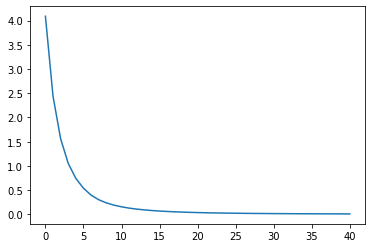

In [16]:
plt.plot(error_history)

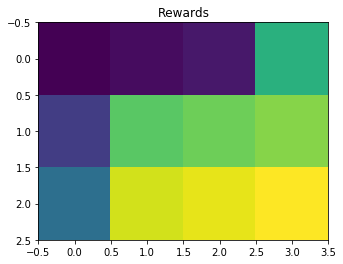

In [17]:
rewards_grid = rewards.reshape((g.length_max, g.height, g.width))
rewards_grid = rewards_grid[0,:,:]

# Map

plt.imshow(rewards_grid);
plt.title('Rewards')
plt.show()

In [18]:
rewards.reshape((g.length_max, g.height, g.width))

array([[[-1.13195329, -1.06192749, -0.99190169,  0.22719791],
        [-0.7380773 ,  0.46390179,  0.54248785,  0.6210739 ],
        [-0.34420131,  0.86633804,  0.93636384,  1.01494989]],

       [[-1.20625899, -1.13623319, -1.06620738,  0.15289222],
        [-0.812383  ,  0.3895961 ,  0.46818215,  0.54676821],
        [-0.41850701,  0.79203234,  0.86205814,  0.9406442 ]],

       [[-1.28056468, -1.21053888, -1.14051308,  0.07858652],
        [-0.88668869,  0.3152904 ,  0.39387646,  0.47246251],
        [-0.4928127 ,  0.71772665,  0.78775245,  0.8663385 ]],

       [[-1.35487038, -1.28484457, -1.21481877,  0.00428083],
        [-0.96099438,  0.24098471,  0.31957076,  0.39815682],
        [-0.56711839,  0.64342095,  0.71344676,  0.79203281]],

       [[-1.42917607, -1.35915027, -1.28912447, -0.07002487],
        [-1.03530008,  0.16667902,  0.24526507,  0.32385113],
        [-0.64142409,  0.56911526,  0.63914106,  0.71772712]]])

In [22]:
def generate_demonstrations(g, policy, n_trajs=10, len_traj=5):
    """gatheres expert demonstrations
    inputs:
    policy      Nx1 matrix
    n_trajs     int - number of trajectories to generate
    rand_start  bool - randomly picking start position or not
    start_pos   2x1 list - set start position, default [0,0]
    returns:
    trajs       a list of trajectories - each element in the list is a list of Steps representing an episode
    """

    trajs = []
    for i in range(n_trajs):
        
        episode = []
        state = (0,1,1)
        idx = g.state2idx(state)
        episode.append(idx)
        
        # while not is_done:
        for _ in range(len_traj-1):

            act = np.random.choice(g.n_actions, p= policy[idx,:])
            next_state = g.get_next_state(state, act)
            next_idx = g.state2idx(next_state)
            episode.append(next_idx)
            state = next_state
            idx = next_idx
            
        trajs.append(episode)
    return trajs

In [23]:
trajs = generate_demonstrations(g, policy, 50, 5)
trajs

[[5, 18, 29, 41, 53],
 [5, 18, 34, 46, 53],
 [5, 22, 30, 46, 53],
 [5, 22, 34, 45, 53],
 [5, 21, 33, 45, 53],
 [5, 18, 31, 46, 53],
 [5, 18, 34, 46, 53],
 [5, 22, 30, 46, 53],
 [5, 17, 34, 41, 53],
 [5, 22, 35, 42, 53],
 [5, 21, 30, 41, 53],
 [5, 22, 34, 46, 53],
 [5, 21, 33, 45, 53],
 [5, 22, 33, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 18, 35, 46, 53],
 [5, 21, 33, 41, 53],
 [5, 17, 34, 46, 53],
 [5, 18, 35, 46, 53],
 [5, 21, 30, 46, 53],
 [5, 22, 33, 41, 53],
 [5, 22, 34, 42, 53],
 [5, 22, 34, 42, 53],
 [5, 17, 34, 46, 53],
 [5, 21, 33, 45, 53],
 [5, 22, 34, 45, 53],
 [5, 22, 33, 45, 53],
 [5, 21, 30, 46, 53],
 [5, 22, 30, 45, 53],
 [5, 18, 30, 46, 53],
 [5, 18, 33, 45, 53],
 [5, 22, 34, 41, 53],
 [5, 21, 34, 46, 53],
 [5, 16, 33, 45, 53],
 [5, 21, 33, 42, 53],
 [5, 16, 29, 45, 53],
 [5, 18, 34, 46, 53],
 [5, 21, 30, 45, 53],
 [5, 22, 29, 41, 53],
 [5, 22, 34, 46, 53],
 [5, 22, 34, 46, 53],
 [5, 21, 29, 46, 53],
 [5, 21, 30, 46, 53],
 [5, 18, 34, 46, 53],
 [5, 21, 3

In [24]:
freq = np.zeros((3,4))
for traj in trajs:
    for idx in traj:
        state = g.idx2state(idx)
        freq[state[1], state[2]] += 1
        
freq

array([[  0.,   0.,   0.,   0.],
       [  2., 114.,  25.,   1.],
       [  0.,  36.,  68.,   4.]])